In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
%pip install scikit-opt
from sko.PSO import PSO
import numpy as np
from scipy.fft import dct, idct
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.weight'] = 'bold'  

Note: you may need to restart the kernel to use updated packages.


# Rosenbrock function

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# ----------- 2D NDCT Basis + Fit + Predict -----------
def ndct2_basis(x, y, Kx, Ky):
    x = np.asarray(x).reshape(-1)
    y = np.asarray(y).reshape(-1)
    kx = np.arange(Kx + 1)
    ky = np.arange(Ky + 1)

    A = []
    for i in kx:
        for j in ky:
            A.append(np.cos(np.pi * x * i) * np.cos(np.pi * y * j))
    return np.vstack(A).T

def ndct2_fit(x, y, z, Kx, Ky, lam=0.0):
    A = ndct2_basis(x, y, Kx, Ky)
    n = A.shape[1]
    if lam and lam > 0:
        ATA = A.T @ A
        ATz = A.T @ z
        c = np.linalg.solve(ATA + lam*np.eye(n), ATz)
    else:
        c = np.linalg.lstsq(A, z, rcond=None)[0]
    return c.reshape(Kx+1, Ky+1)

def ndct2_predict(X, Y, coeffs):
    Kx, Ky = coeffs.shape[0]-1, coeffs.shape[1]-1
    Zhat = np.zeros_like(X, dtype=float)
    for i in range(Kx+1):
        for j in range(Ky+1):
            Zhat += coeffs[i, j] * np.cos(np.pi * i * X) * np.cos(np.pi * j * Y)
    return Zhat

# ----------- Demo: Rosenbrock 函数 -----------
N = 50
x_lin = np.linspace(0.1, 1.9, N)
y_lin = np.linspace(0.1, 1.9, N)
X, Y = np.meshgrid(x_lin, y_lin)


X_flat = X.flatten()
Y_flat = Y.flatten()
M = X_flat.shape[0]
np.random.seed(16)  

m = 1250
idx = np.random.choice(M, m, replace=False)
x_samples = X_flat[idx]
y_samples = Y_flat[idx]
z_samples = (1 - x_samples)**2 + 100*(y_samples - x_samples**2)**2

sigma = 0.1   
z_samples = z_samples + np.random.normal(0, sigma, size=z_samples.shape)
#normalize 
x_scaled = x_samples / 2
y_scaled = y_samples / 2



C:\Users\16941\AppData\Local\Temp\ipykernel_14096\2547144695.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc='upper left')


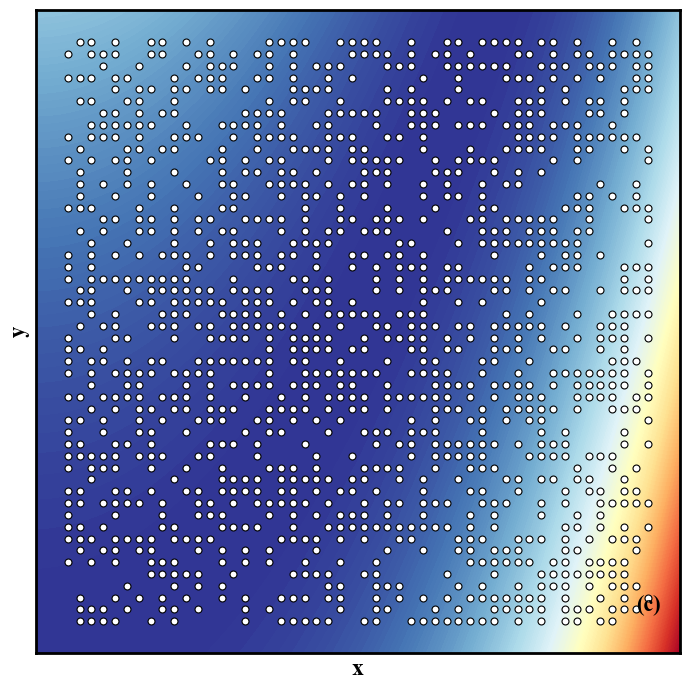

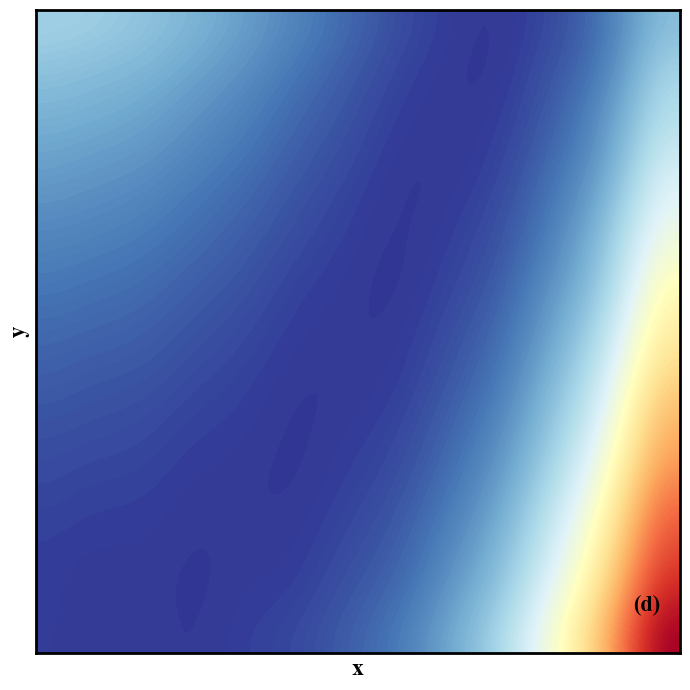

In [ ]:

t = 12
Kx, Ky = t, t
coeffs = ndct2_fit(x_scaled, y_scaled, z_samples, Kx, Ky, lam=1e-6)


Xg, Yg = np.meshgrid(np.linspace(0,2,200), np.linspace(0,2,200))
Xg_scaled = Xg / 2
Yg_scaled = Yg / 2
Zhat = ndct2_predict(Xg_scaled, Yg_scaled, coeffs)


Ztrue = (1 - Xg)**2 + 100*(Yg - Xg**2)**2





fig, ax = plt.subplots(figsize=(7,7))
cs0 = ax.contourf(Xg, Yg, Ztrue, levels=200, cmap="RdYlBu_r")
ax.scatter(x_samples, y_samples, facecolors='white', edgecolors='black',
           s=25, linewidths=0.8, marker='o')
ax.set_xlabel('x', fontweight="bold", fontsize=17); ax.set_ylabel('y', fontweight="bold", fontsize=16)
ax.text(0.97, 0.09, "(c)", transform=ax.transAxes,
        fontsize=16, fontweight="bold", ha="right", va="top")
ax.legend(frameon=False, loc='upper left')

ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)


for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.tight_layout()
# save_path = r"D:\lib\gali\Manuscript\fig3-2D-20x20\c.png"
# plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=(7,7))
cs1 = ax.contourf(Xg, Yg, Zhat, levels=200, cmap="RdYlBu_r")
ax.set_xlabel('x', fontweight="bold", fontsize=17); ax.set_ylabel('y', fontweight="bold", fontsize=16)
ax.text(0.97, 0.09, "(d)", transform=ax.transAxes,
        fontsize=16, fontweight="bold", ha="right", va="top")

ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)


for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.tight_layout()
# save_path = r"D:\lib\gali\Manuscript\fig3-2D-20x20\d.png"
# plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
def ndct2_objective(Xin):
    """
    Xin: shape (2,) 或 (pop, 2) ; 返回标量或一维数组
    作用: 在 [0,2]^2 上取点 (x,y)，内部按 /2 归一化到 [0,1] 后，
         用 NDCT 系数 coeffs 预测 Zhat，并取负作为 PSO 的目标。
    """
    A = np.asarray(Xin, dtype=float)
    Kx, Ky = coeffs.shape[0]-1, coeffs.shape[1]-1
    i = np.arange(Kx+1)
    j = np.arange(Ky+1)

    if A.ndim == 1:
        x, y = A
        xs, ys = x/2.0, y/2.0
        cx = np.cos(np.pi * xs * i)             # (Kx+1,)
        cy = np.cos(np.pi * ys * j)             # (Ky+1,)
        z  = cx @ coeffs @ cy                 
        return float(z)                      
    else:
        X = A[:, 0]; Y = A[:, 1]                # (pop,)
        xs, ys = X/2.0, Y/2.0
        Cx = np.cos(np.pi * xs[:, None] * i[None, :])   # (pop, Kx+1)
        Cy = np.cos(np.pi * ys[:, None] * j[None, :])   # (pop, Ky+1)
        R  = Cy @ coeffs.T                               # (pop, Kx+1)
        z  = np.sum(Cx * R, axis=1)                      # (pop,)
        return z                                       

In [ ]:
# —— 运行 2D modified PSO —— 
from pso_new import PSO_new

pso2 = PSO_new(
    func=ndct2_objective, n_dim=2, pop=30, max_iter=151,
    lb=[0.0, 0.0], ub=[2.0, 2.0],

    w_min=0.4, w_max=0.9,
   
    beta_center=0.3, sigma_pert=0.01, anneal_pert=True,
    
    de_interval=10, de_rate=0.25, de_F=0.5, de_CR=0.9,
    verbose=False
)
pso2.record_mode = True
best_xy, best_neg = pso2.run(precision=1e-6, N=20, stop_mode="fitness")  
best_val = -float(best_neg)   
print("best (x,y):", np.round(best_xy, 6), "  best surrogate value:", best_val)

best (x,y): [1.094017 1.179202]   best surrogate value: 1.25971320358781


C:\Users\16941\AppData\Local\Temp\ipykernel_14096\3492131541.py:21: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x0000020AB59BA700>' will be ignored
  c.set_rasterized(True)


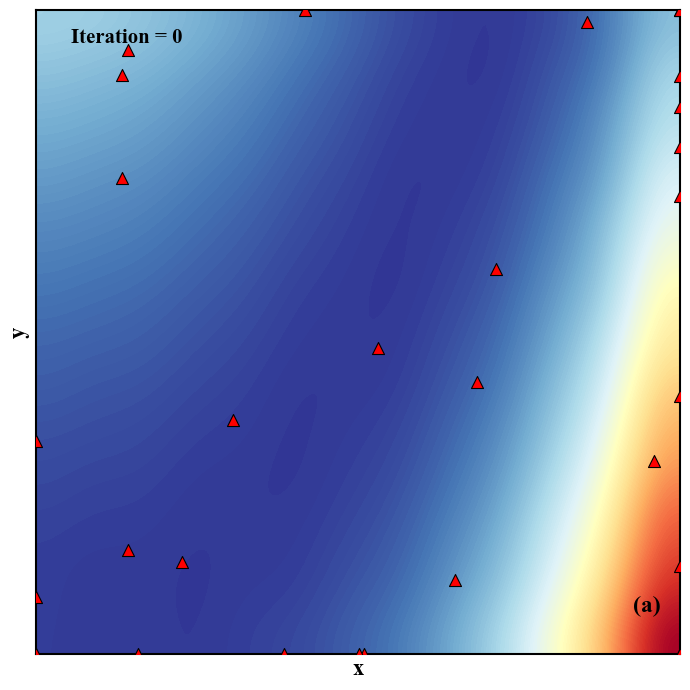

C:\Users\16941\AppData\Local\Temp\ipykernel_14096\3492131541.py:21: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x0000020ABB3E3220>' will be ignored
  c.set_rasterized(True)


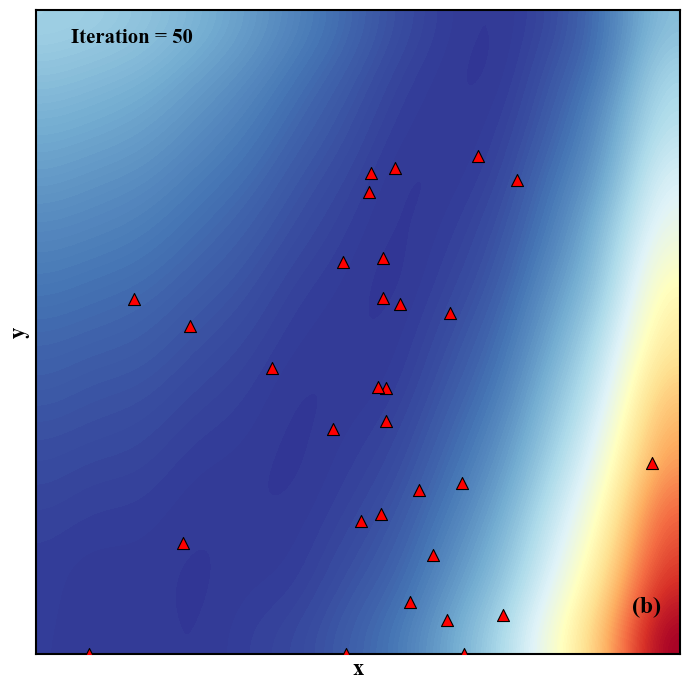

C:\Users\16941\AppData\Local\Temp\ipykernel_14096\3492131541.py:21: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x0000020AB6C3E3D0>' will be ignored
  c.set_rasterized(True)


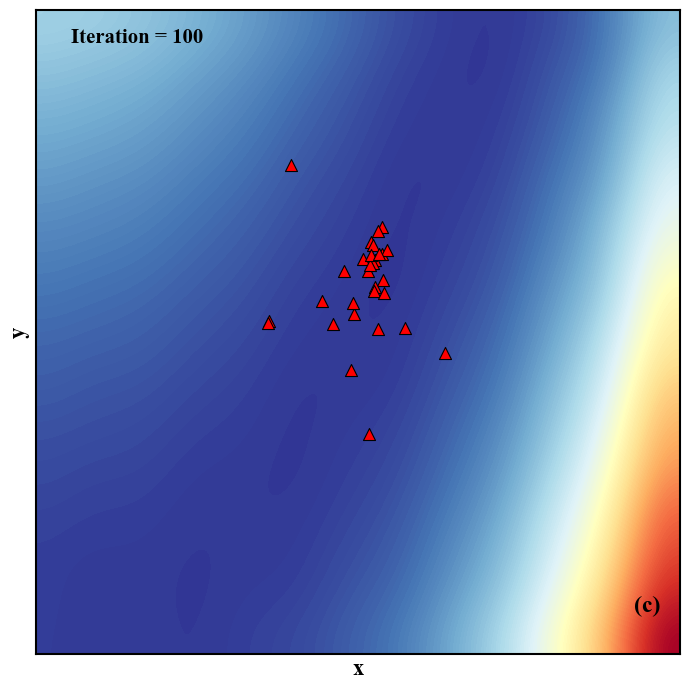

C:\Users\16941\AppData\Local\Temp\ipykernel_14096\3492131541.py:21: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x0000020AB59A4880>' will be ignored
  c.set_rasterized(True)


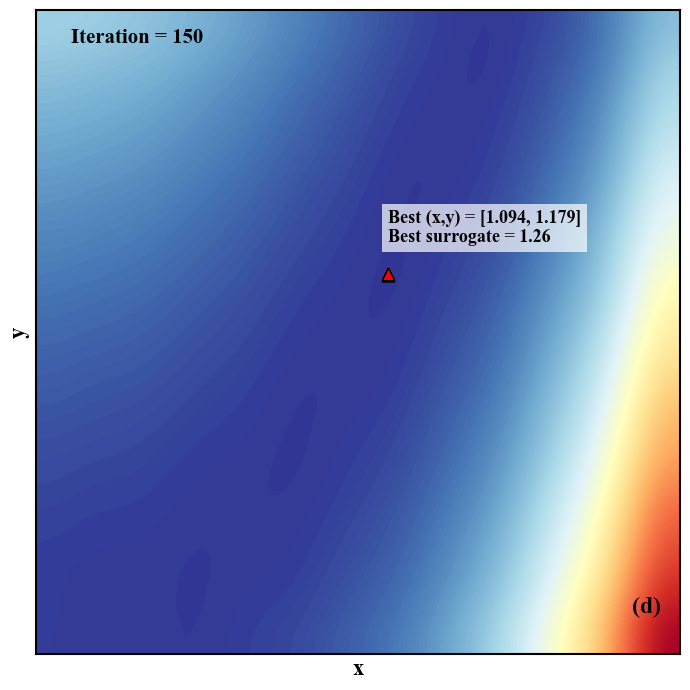

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

target_iters = [0, 50, 100, 150]
panel_tags = ["(a)", "(b)", "(c)", "(d)"]

pso_ref = pso2 if 'pso2' in globals() else pso


best_x, best_y = 1.094017, 1.179202
best_val = 1.25971320358781

for idx, target_iter in enumerate(target_iters):
    fig, ax = plt.subplots(figsize=(7,7))

   
    ax.contourf(Xg, Yg, Zhat, levels=200, cmap="RdYlBu_r")
    for c in ax.collections:
        c.set_rasterized(True)

 
    ax.set_xlabel('x', fontweight="bold", fontsize=16)
    ax.set_ylabel('y', fontweight="bold", fontsize=16)
    ax.text(0.97, 0.09, panel_tags[idx], transform=ax.transAxes,
            fontsize=17, fontweight="bold", ha="right", va="top")

   
    idx_snapshot = max(0, min(target_iter - 1, len(pso_ref.record_value['X']) - 1))
    P = pso_ref.record_value['X'][idx_snapshot]  # shape (pop, 2)

    ax.scatter(
        P[:, 0], P[:, 1],
        c="red", s=75, marker="^", edgecolors="black", linewidths=0.8,
        label=f"PSO Particles (Iter={target_iter})",
        zorder=3
    )

    
    if target_iter == 150:  
        
        ax.text(best_x, best_y+0.1,
                f"Best (x,y) = [{best_x:.3f}, {best_y:.3f}]\nBest surrogate = {best_val:.2f}",
                fontsize=13, fontweight="bold", color="black",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

 
    ax.set_xticks([]); ax.set_yticks([])
    ax.tick_params(axis='both', which='both', length=0,
                   labelbottom=False, labelleft=False)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)


    text_only = Line2D([], [], linestyle='None', label=f"Iteration = {target_iter}")
    ax.legend(handles=[text_only], loc='upper left', fontsize=15,
              frameon=False, handlelength=0)

    save_path = fr"D:\lib\gali\Manuscript\figS4\{panel_tags[idx][1]}.svg"
    plt.tight_layout()
    plt.savefig(save_path, format="svg", dpi=600, bbox_inches='tight')
    plt.show()
